In [1]:
from collections import defaultdict

import pandas as pd
import pyprojroot
import searchnets
import seaborn as sns
import torch
import torch.nn
from tqdm import tqdm

In [2]:
def dist_mat(x):
    """distance matrix"""    
    if len(x.size()) == 4:
        x = x.view(x.size()[0], -1)

    dist = torch.norm(x[:, None] - x, dim=2)
    return dist

In [3]:
def kernel_alignment_loss(k_x, k_y, k_l):
    """computes kernel alignment loss (Crisitiani et al. 2002)"""
    beta = 1.0

    L = torch.norm(k_l)
    Y = torch.norm(k_y) ** beta
    X = torch.norm(k_x) ** (1-beta)

    LY = torch.trace(torch.matmul(k_l, k_y)) ** beta
    LX = torch.trace(torch.matmul(k_l, k_x)) ** (1 - beta)

    return 2 * torch.log2((LY * LX) / (L * Y * X))

In [4]:
def kernel_mat(x, k_x, k_y, sigma=None, idx=None):
    d = dist_mat(x)
    if sigma is None:
        sigma_vals = torch.linspace(0.3, 10 * d.mean(), 100).cuda()
        L = []
        for sig in sigma_vals:
            k_l = torch.exp(-d ** 2 / (sig ** 2)) / d.size(0)
            L.append(
                kernel_alignment_loss(k_x, k_y, k_l)
            )

#         if epoch == 0:
#             self.sigmas[idx+1, epoch] = sigma_vals[L.index(max(L))]
#         else:
#             self.sigmas[idx+1, epoch] = 0.9*self.sigmas[idx+1, epoch-1] + 0.1*sigma_vals[L.index(max(L))]
#
#         sigma = self.sigmas[idx+1, epoch]
        sigma = sigma_vals[L.index(max(L))]
    return torch.exp(-d ** 2 / (sigma ** 2))

In [5]:
def entropy(*tensors):
    """computes matrix-based Renyi's \alpha-order entropy,
    in the limit when \alpha --> 1, 
    i.e., matrix–based von Neumann entropy

    equation (3) in Wickstrøm et al. 2019"""
    for idx, val in enumerate(tensors):  # iterate along batch dimension
        if idx == 0:
            k = val.clone()
        else:
            k *= val

    k /= k.trace()
    eigv = torch.symeig(k)[0].abs()

    return -(eigv * (eigv.log2())).sum()

In [6]:
ACTIVATIONS = {}

def get_activation(op_name):
    def hook(model, input, output):
        ACTIVATIONS[op_name] = output.detach()
    return hook

In [7]:
DEVICE = 'cuda'

In [8]:
NUM_CLASSES = 2  # target absent (0) or present (1)

In [9]:
ckpts_root = pyprojroot.here() / 'results' / 'searchstims' / 'checkpoints'
expt_root = ckpts_root / '3stims'
init_root = expt_root / 'alexnet_initialize_lr_1e-03_three_stims_38400samples_balanced'
tsfr_root = expt_root / 'alexnet_transfer_lr_1e-03_no_finetune_three_stims_38400samples_balanced'

models = {}
for train_type, ckpt_root in zip(
    ('initialize', 'transfer'),
    (init_root, tsfr_root),
):
    net_root = ckpt_root / 'trained_200_epochs/net_number_1'
    ckpt_path = net_root / 'alexnet_trained_200_epochs_number_1-best-val-acc-ckpt.pt'
    model = searchnets.nets.alexnet.build(
        pretrained=False, 
        progress=False, 
        num_classes=NUM_CLASSES
    )
    model.to(DEVICE);
    
    checkpoint = torch.load(ckpt_path)
    model = torch.nn.DataParallel(model)
    model.load_state_dict(checkpoint['model'])
    
    models[train_type] = model

In [14]:
model.module.classifier[-5]

ReLU(inplace=True)

In [11]:
for train_type, model in models.items():
    # we want to collect activations from the last linear transform
    model.module.classifier[-2].register_forward_hook(get_activation(op_name=f'{train_type}-last-fc'))

In [12]:
DATASET_TYPE = 'searchstims'
LOSS_FUNC = 'CE'

transform, target_transform = searchnets.transforms.util.get_transforms(
    dataset_type=DATASET_TYPE,
    loss_func=LOSS_FUNC, 
    pad_size=500  # no effect since we're using searchstims not VOC
)

CSV_FILE = pyprojroot.here() / '../visual_search_stimuli/alexnet_multiple_stims/alexnet_three_stims_38400samples_balanced_split.csv'

testset = searchnets.datasets.Searchstims(
    csv_file=CSV_FILE,
    split='test',
    transform=transform,
    target_transform=target_transform
)

BATCH_SIZE = 100
SHUFFLE = True  # because we want to randomly sample set size, target present / absent, etc.
NUM_WORKERS = 4
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [19]:
for train_type, model in models.items():
    model.eval()

S_by_train_type = defaultdict(list)
records = []

pbar = tqdm(test_loader)
N_BATCHES = 100
for i, batch in enumerate(pbar):
    if i == N_BATCHES:
        break

    x, y_true, set_size = batch['img'].to(DEVICE), batch['target'].to(DEVICE), batch['set_size']

    y_onehot = torch.nn.functional.one_hot(y_true).float()
    k_x = kernel_mat(x, [], [], sigma=torch.tensor(8.0))
    k_y = kernel_mat(y_onehot, [], [], sigma=torch.tensor(0.1))

    activations_by_train_type = {}
    for train_type, model in models.items():
        with torch.no_grad():
            output = model(x)
            activations_by_train_type[train_type] = ACTIVATIONS[f'{train_type}-last-fc']

    for train_type, activation in activations_by_train_type.items():
            k = kernel_mat(activation.flatten(start_dim=1), k_x, k_y)
            s = entropy(k).cpu().numpy().item()
            S_by_train_type[train_type].append(s)
    # below, _ because torch.max returns (values, indices)
#     _, y_pred = torch.max(output.data, 1)    
#     correct = y_pred == y_true
#     acc = correct.sum().item() / y_true.size(0)

#     for y_true_el, set_size, y_pred_el, activation_el in zip(
#         y_true.cpu().numpy(),
#         set_size.cpu().numpy(),
#         y_pred.cpu().numpy(),
#         activation.cpu().numpy()
#     ):
#         records.append(
#             {
#                 'y_true': y_true_el,
#                 'set_size': set_size,
#                 'y_pred': y_pred_el,
#                 'activation': activation
#             }
#         )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:09<00:00,  7.02it/s]


In [20]:
records = []
for train_type, s_vals in S_by_train_type.items():
    for batch_num, s_val in enumerate(s_vals):
        records.append(
            {
                'train_type': train_type,
                'batch': batch_num,
                'entropy': s_val,
            }
        )
data = pd.DataFrame.from_records(records)

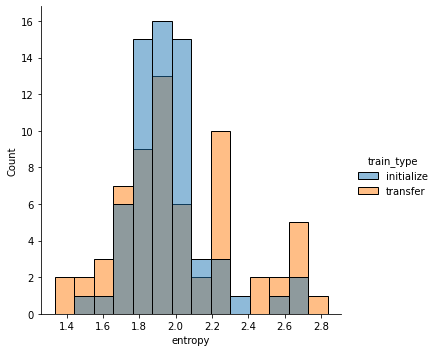

In [21]:
sns.displot(data, x='entropy', hue='train_type')